In [1]:
import datasets
import peft
import pickle
import pytest, ipytest
import transformers

from datasets import(
    load_dataset, 
    load_dataset_builder,
    get_dataset_split_names,
    get_dataset_config_names,
)

from peft import(
    LoftQConfig,
    LoraConfig,
    get_peft_model,
)

from transformers import(
    AutoModelForCausalLM,
    AutoTokenizer,
    TrainingArguments,
    Trainer
)
from trl import SFTTrainer, SFTConfig
# allows fast processing of datasets

/home/ac.cdavies/.vnv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-04-03 17:06:16.276901: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743699976.290765 2815243 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743699976.294982 2815243 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743699976.307117 2815243 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 

In [2]:
%run training_functions.ipynb

## Imported Functions
1. model_from_pkl(model): extracts ML model from pkl file
2. map_data(data, model, tokenizer): performs preprocessing/tokenization on data
3. make_trainer(m_model, train_data, test_data, config, args): creates training object with model, training arguments, train/test data, a configuration, and evaluation function
4. compute_metrics(eval_pred): used in the trainer, calculates prediction accuracy/validation loss
5. get_training_output(trainer, keys: list): extracts data from training logs
6. get_dataframe(training_output: list, strategy): used in get_training_output, puts training data into dataframe/graph form

In [3]:
ds_builder1=load_dataset_builder("LongSafari/open-genome", "stage1")
print(ds_builder1.info.features)
ds_builder2=load_dataset_builder("LongSafari/open-genome", "stage2")
print(ds_builder2.info.features)
ds_builder3=load_dataset_builder("LongSafari/open-genome", "sample")
print(ds_builder3.info.features)

{'record': Value(dtype='string', id=None), 'text': Value(dtype='string', id=None)}
{'text': Value(dtype='string', id=None)}
{'text': Value(dtype='string', id=None)}


In [4]:
ds_gs=load_dataset("LongSafari/open-genome", "sample")
get_dataset_split_names("LongSafari/open-genome", "sample")

['validation']

In [5]:
ds_gst1_train=load_dataset("LongSafari/open-genome", "stage1", split="train[:500]")
#print(ds_gst1[50])
ds_gst1_test=load_dataset("LongSafari/open-genome", "stage1", split="test[:50]")
print(get_dataset_split_names("LongSafari/open-genome", "stage1"))
ds_gst2_train=load_dataset("LongSafari/open-genome", "stage2", split="train[:500]")
ds_gst2_test=load_dataset("LongSafari/open-genome", "stage2", split="test[:50]")
print(get_dataset_split_names("LongSafari/open-genome", "stage2"))

['train', 'validation', 'test']
['train', 'validation', 'test']


In [6]:
mistral, mistral_tokenizer=model_from_pkl("Mistral-7B-Instruct-v0.1")

In [7]:
m_tokenized_genome_samples=map_data(ds_gs, mistral, mistral_tokenizer)

In [8]:
m_tokenized_stage1_train=map_data(ds_gst1_train, mistral, mistral_tokenizer)
m_tokenized_stage1_test=map_data(ds_gst1_test, mistral, mistral_tokenizer)

Map: 100%|████████████████| 500/500 [00:02<00:00, 224.65 examples/s]


In [9]:
m_tokenized_stage2_train=map_data(ds_gst2_train, mistral, mistral_tokenizer)
m_tokenized_stage2_test=map_data(ds_gst2_test, mistral, mistral_tokenizer)

Map: 100%|██████████████████| 50/50 [00:00<00:00, 243.63 examples/s]


In [10]:
# to fine-tune with LoRA, instantiate a base model (as above)
# create LoraConfig where LoRA-specific parameters are defined
config=LoraConfig(
    #inference_mode=False,
    r=8, #rank of update matrices, lower value results in smaller matrices with fewer parameters
    lora_alpha=16, #LoRA scaling factor
    task_type="CAUSAL_LM",
    lora_dropout=0.1, # dropout probability of LoRA layers
    bias="none", # specifies if bias parameters should be trained
    #modules_to_save=["decode_head"] #models apart from LoRA layers that are trainable
)

In [11]:
mis_lora_model=get_peft_model(mistral, config)
print_trainable_parameters(mis_lora_model)

trainable params: 3407872 || all params: 7245139968 || trainable%: 0.05


In [12]:
m_trainer = make_trainer(mis_lora_model, m_tokenized_stage1_train, m_tokenized_stage1_test, config,
                          SFTConfig(output_dir="test_trainer", eval_strategy="steps",
                                    logging_strategy="steps", 
                                    logging_steps=6, do_eval=True, 
                                    #max_length=1024,
                                    per_device_eval_batch_size=8,
                                   fp16=True))

# Using the SFTConfig default values provides us with...
# num_train_epochs = 3.0
# eval_strategy: typing.Union[transformers.trainer_utils.IntervalStrategy, str] = 'no'
# per_device_train_batch_size = 8
# learning_rate = 2e-5
# gradient_checkpointing=False

Truncating train dataset: 100%|█| 500/500 [00:00<00:00, 3416.14 exam


In [13]:
m_trainer.train()

/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
6,0.652200,2.566921,0.026465
12,0.643100,2.522748,0.025957
18,0.630700,2.495386,0.026758
24,0.629400,2.480132,0.028672
30,0.626000,2.471052,0.028477
36,0.623500,2.465236,0.028711
42,0.620300,2.461953,0.029473
48,0.622600,2.460880,0.029336


/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch

TrainOutput(global_step=48, training_loss=0.6309662908315659, metrics={'train_runtime': 828.8314, 'train_samples_per_second': 1.81, 'train_steps_per_second': 0.058, 'total_flos': 6.5563250393088e+16, 'train_loss': 0.6309662908315659})

,loss,eval_loss,eval_accuracy
steps,,,
6,0.6522,2.566921,0.026465
12,0.6431,2.522748,0.025957
18,0.6307,2.495386,0.026758
24,0.6294,2.480132,0.028672
30,0.6260,2.471052,0.028477
36,0.6235,2.465236,0.028711
42,0.6203,2.461953,0.029473
48,0.6226,2.460880,0.029336


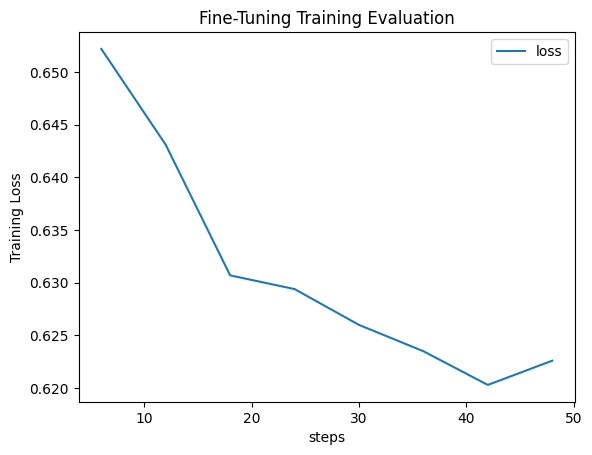

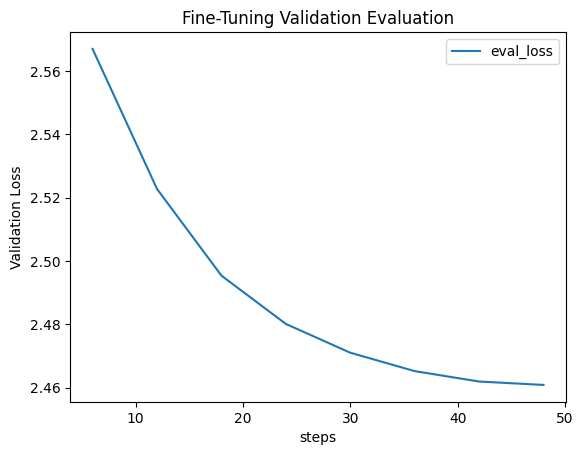

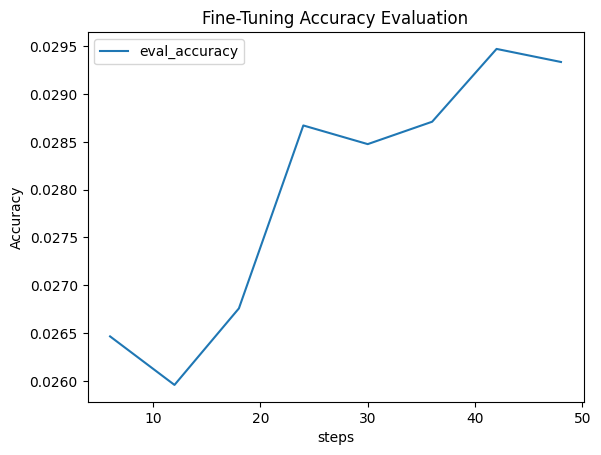

In [14]:
output=get_training_output(m_trainer, ['loss', 'eval_loss', 'eval_accuracy'])
output

In [16]:
m2_trainer = make_trainer(mis_lora_model, m_tokenized_stage1_train, m_tokenized_stage1_test, config,
                          SFTConfig(output_dir="test_trainer", eval_strategy="epoch",
                                    logging_strategy="steps", 
                                    logging_steps=2, do_eval=True, 
                                    #max_length=1024,
                                    per_device_eval_batch_size=8,
                                   fp16=True))

In [17]:
m2_trainer.train()

/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.614000,2.440665,0.002773
2,0.612000,2.432979,0.007930
3,0.616500,2.430408,0.006973


/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


TrainOutput(global_step=48, training_loss=0.6155575836698214, metrics={'train_runtime': 362.7142, 'train_samples_per_second': 4.135, 'train_steps_per_second': 0.132, 'total_flos': 6.5563250393088e+16, 'train_loss': 0.6155575836698214})

,loss,eval_loss,eval_accuracy
epoch,,,
1.0,0.6140,2.440665,0.002773
2.0,0.6120,2.432979,0.007930
3.0,0.6165,2.430408,0.006973


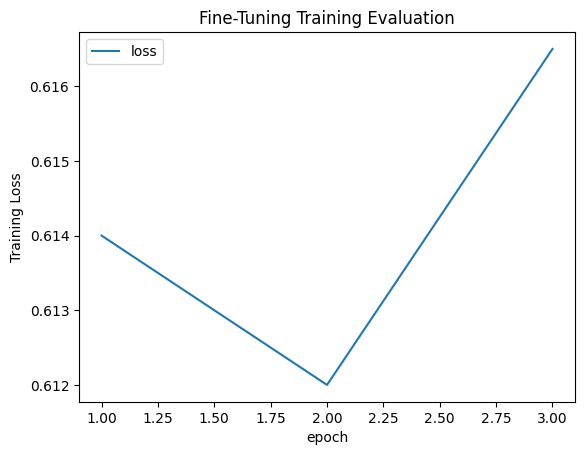

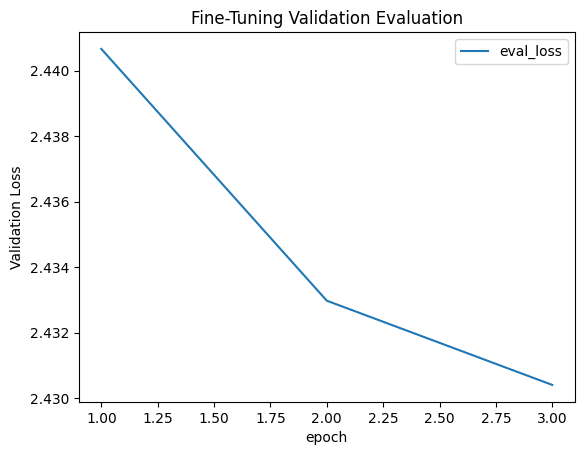

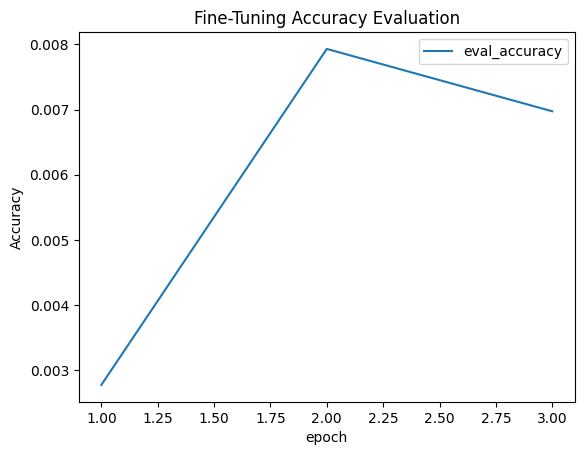

In [18]:
output=get_training_output(m2_trainer, ['loss', 'eval_loss', 'eval_accuracy'])
output

In [ ]:
# m_trainer.model.save_pretrained('./fine_tuned_mis/')
# m2_trainer.model.save_pretrained('./fine_tuned_mis2/')